In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import DenseNet121
tf.get_logger().setLevel('INFO')
from sklearn.decomposition import PCA
from sklearn.utils import resample
import zipfile
import os
from PIL import Image
import sys


In [2]:
embedded_images = pd.read_csv("/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207_AppliedML/Final_Project/rxrx2/embeddings.csv")
metadata = pd.read_csv("/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207_AppliedML/Final_Project/rxrx2/metadata.csv")

In [3]:
embedded_images.head(20)

,site_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,HUVEC-1_1_AA03_1,-0.316918,-0.680636,0.808178,-0.137503,-0.947040,-2.796024,-1.386294,-2.541984,-0.036722,...,0.044025,0.136659,-2.087172,2.860377,0.231014,0.338580,-0.504502,-1.992612,-1.328181,0.587981
1,HUVEC-1_1_AA03_2,0.914670,-0.009687,1.157437,0.448207,-0.546811,-1.792279,-1.283470,-1.500057,0.508764,...,0.508053,0.828908,-2.586799,1.503782,-0.482412,0.894832,-1.406880,-1.567457,-1.237937,0.967158
2,HUVEC-1_1_AA03_3,0.384831,-0.630163,0.844492,0.078680,-1.497208,-3.127449,-0.617015,-1.984535,-0.062243,...,-1.566359,0.798682,-2.241158,2.297683,0.340067,-0.032073,-0.765850,-1.615617,-2.184443,0.673777
3,HUVEC-1_1_AA03_4,0.733473,-0.329016,1.319193,0.433355,-0.801268,-2.489902,-0.668106,-1.722575,-0.463873,...,-0.313790,0.446107,-2.883605,1.824921,-0.252444,-0.125901,-1.181341,-1.027408,-1.475612,0.640989
4,HUVEC-1_1_AA04_1,0.512833,0.402055,1.318915,-1.067507,-2.031572,-1.260452,-1.287148,-2.538712,-0.367633,...,-0.584362,-0.101393,-2.937795,2.197699,-0.537146,0.019088,-0.495586,-1.710877,-2.491404,0.924014
5,HUVEC-1_1_AA04_2,0.685602,-0.449330,-0.036173,0.566339,-1.345518,-2.758372,0.337740,-2.069584,-0.405746,...,-0.632067,0.844820,-3.025629,2.695810,0.306507,-0.764635,-0.768099,-1.869005,-1.870727,1.021658
6,HUVEC-1_1_AA04_3,0.727056,-0.127391,0.075612,-0.208260,-1.547239,-2.798045,-1.160213,-2.140850,-0.030790,...,-1.631549,0.545518,-2.310471,2.565591,-0.273869,0.521701,-0.443988,-1.436595,-1.964662,0.735162
7,HUVEC-1_1_AA04_4,1.014329,0.110145,1.379816,0.155982,-1.694931,-2.207772,-0.440026,-1.718514,-0.050229,...,-0.884933,0.409745,-3.268776,2.491673,-0.278280,0.139286,-1.183563,-1.582847,-1.861125,0.990245
8,HUVEC-1_1_AA05_1,0.350081,-0.069644,0.218782,-0.506698,-1.748009,-1.350738,-0.981009,-2.737542,-0.240257,...,-1.067775,0.014349,-2.353183,2.771362,-0.012947,0.152623,-0.297514,-1.015742,-2.478446,0.722264
9,HUVEC-1_1_AA05_2,0.564962,-0.211768,0.482409,0.357695,-1.255980,-2.357686,-0.943967,-2.373645,-0.275689,...,-1.354843,0.389791,-3.352989,2.610169,0.088752,-0.177975,-1.095216,-1.632764,-2.196692,0.764327


In [4]:
print(metadata.columns)
metadata.head()

Index(['site_id', 'well_id', 'cell_type', 'experiment', 'plate', 'well',
       'site', 'treatment', 'treatment_conc'],
      dtype='object')


,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc
0,HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,Sonic-Hedgehog,0.1
1,HUVEC-1_1_AA03_2,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,2,Sonic-Hedgehog,0.1
2,HUVEC-1_1_AA03_3,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,3,Sonic-Hedgehog,0.1
3,HUVEC-1_1_AA03_4,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,4,Sonic-Hedgehog,0.1
4,HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,GDF-1,0.1


In [5]:
metadata['well_id'].unique()

array(['HUVEC-1_1_AA03', 'HUVEC-1_1_AA04', 'HUVEC-1_1_AA05', ...,
       'HUVEC-2_12_Z45', 'HUVEC-2_12_Z46', 'HUVEC-2_12_Z47'], dtype=object)

In [6]:
#had to convert them both to string
embedded_images["site_id"] = embedded_images["site_id"].astype(str)
metadata["site_id"] = metadata["site_id"].astype(str)

metadata.head()


,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc
0,HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,Sonic-Hedgehog,0.1
1,HUVEC-1_1_AA03_2,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,2,Sonic-Hedgehog,0.1
2,HUVEC-1_1_AA03_3,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,3,Sonic-Hedgehog,0.1
3,HUVEC-1_1_AA03_4,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,4,Sonic-Hedgehog,0.1
4,HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,GDF-1,0.1


Mapping the immune modulators becasue that is what we care about

In [7]:
# Define treatment categories mapping
# Define treatment categories and subcategories
immune_modulators = {
    "Pro-inflammatory Cytokines": [
        "TNF-alpha", "IL-1-beta", "IL-6", "IL-17A", "IL-17B", "IL-17E", "IL-17F", "IL-12", "IL-23"
    ],
    "Anti-inflammatory Cytokines": [
        "IL-4", "IL-10", "IL-13", "IL-27", "IL-35"
    ],
    "Chemokines": [
        "CCL1", "CCL4", "CCL14a", "CCL21", "CXCL16", "MIP-1a", "MIP-3a", "MIP-3b", "MCP-1", "MCP-3", "MCP-4-"
    ],
    "Interferons": [
        "IFN-alpha-A", "IFN-beta", "IFN-gamma", "IFN-omega"
    ],
    "Toll-Like Receptor (TLR) Agonists": [
        "TLR-4", "Poly_IC_HMW", "Poly_IC_LMW", "ssRNA40", "LPS_EK"
    ],
    "Macrophage & T-cell Regulators": [
        "M-CSF", "GM-CSF", "OX40", "HVEM", "CD40-Ligand", "CTLA-4"
    ],
    "Complement System Activators": [
        "C5a", "Complement C2", "Factor-D", "Factor-H", "Factor-X"
    ]
}

# Create a lookup dictionary for fast mapping
immune_treatment_to_category = {}
for subcategory, treatments in immune_modulators.items():
    for treatment in treatments:
        immune_treatment_to_category[treatment] = ("Immune System Modulators", subcategory)

# Function to assign category and subcategory
def categorize_treatment(treatment):
    if treatment == "EMPTY":
        return "Control", "Control"  # Control case
    return immune_treatment_to_category.get(treatment, ("N/A", "N/A"))  # Assign category if found, else N/A

# Apply the categorization to the dataframe
metadata[["treatment_category", "treatment_subcategory"]] = metadata["treatment"].apply(lambda x: pd.Series(categorize_treatment(x)))

In [8]:
#check categorization has worked
metadata['treatment'].value_counts()

treatment
EMPTY             7579
Sonic-Hedgehog     288
CV-2               288
TNF-alpha          288
FGF-9              288
                  ... 
tri_daP            284
Noggin             282
CsAT               274
SaHla              265
BpACT              192
Name: count, Length: 434, dtype: int64

In [9]:
#remove the NA rows
immune_df = metadata[metadata["treatment_category"] != "N/A"]

In [10]:
immune_df

,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,treatment_category,treatment_subcategory
8,HUVEC-1_1_AA05_1,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,1,CCL14a,0.100000,Immune System Modulators,Chemokines
9,HUVEC-1_1_AA05_2,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,2,CCL14a,0.100000,Immune System Modulators,Chemokines
10,HUVEC-1_1_AA05_3,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,3,CCL14a,0.100000,Immune System Modulators,Chemokines
11,HUVEC-1_1_AA05_4,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,4,CCL14a,0.100000,Immune System Modulators,Chemokines
48,HUVEC-1_1_AA15_1,HUVEC-1_1_AA15,HUVEC,HUVEC-1,1,AA15,1,MIP-3a,0.100000,Immune System Modulators,Chemokines
...,...,...,...,...,...,...,...,...,...,...,...
131880,HUVEC-2_12_Z29_4,HUVEC-2_12_Z29,HUVEC,HUVEC-2,12,Z29,4,IFN-gamma,0.000001,Immune System Modulators,Interferons
131881,HUVEC-2_12_Z30_1,HUVEC-2_12_Z30,HUVEC,HUVEC-2,12,Z30,1,EMPTY,NaN,Control,Control
131882,HUVEC-2_12_Z30_2,HUVEC-2_12_Z30,HUVEC,HUVEC-2,12,Z30,2,EMPTY,NaN,Control,Control
131883,HUVEC-2_12_Z30_3,HUVEC-2_12_Z30,HUVEC,HUVEC-2,12,Z30,3,EMPTY,NaN,Control,Control


In [11]:
immune_df['treatment_subcategory'].value_counts()

treatment_subcategory
Control                              7579
Chemokines                           2590
Pro-inflammatory Cytokines           2588
Macrophage & T-cell Regulators       1727
Toll-Like Receptor (TLR) Agonists    1437
Complement System Activators         1436
Anti-inflammatory Cytokines          1436
Interferons                           863
Name: count, dtype: int64

In [12]:
immune_df[immune_df['treatment_subcategory']=='Anti-inflammatory Cytokines']

,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,treatment_category,treatment_subcategory
612,HUVEC-1_1_AD19_1,HUVEC-1_1_AD19,HUVEC,HUVEC-1,1,AD19,1,IL-10,0.100000,Immune System Modulators,Anti-inflammatory Cytokines
613,HUVEC-1_1_AD19_2,HUVEC-1_1_AD19,HUVEC,HUVEC-1,1,AD19,2,IL-10,0.100000,Immune System Modulators,Anti-inflammatory Cytokines
614,HUVEC-1_1_AD19_3,HUVEC-1_1_AD19,HUVEC,HUVEC-1,1,AD19,3,IL-10,0.100000,Immune System Modulators,Anti-inflammatory Cytokines
615,HUVEC-1_1_AD19_4,HUVEC-1_1_AD19,HUVEC,HUVEC-1,1,AD19,4,IL-10,0.100000,Immune System Modulators,Anti-inflammatory Cytokines
724,HUVEC-1_1_AD47_1,HUVEC-1_1_AD47,HUVEC,HUVEC-1,1,AD47,1,IL-4,0.100000,Immune System Modulators,Anti-inflammatory Cytokines
...,...,...,...,...,...,...,...,...,...,...,...
131461,HUVEC-2_12_X16_4,HUVEC-2_12_X16,HUVEC,HUVEC-2,12,X16,4,IL-10,0.000001,Immune System Modulators,Anti-inflammatory Cytokines
131805,HUVEC-2_12_Z11_1,HUVEC-2_12_Z11,HUVEC,HUVEC-2,12,Z11,1,IL-35,0.000001,Immune System Modulators,Anti-inflammatory Cytokines
131806,HUVEC-2_12_Z11_2,HUVEC-2_12_Z11,HUVEC,HUVEC-2,12,Z11,2,IL-35,0.000001,Immune System Modulators,Anti-inflammatory Cytokines
131807,HUVEC-2_12_Z11_3,HUVEC-2_12_Z11,HUVEC,HUVEC-2,12,Z11,3,IL-35,0.000001,Immune System Modulators,Anti-inflammatory Cytokines


In [13]:

# Define the base directory
base_dir = "/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207_AppliedML/Final_Project/rxrx2/immune_images"


# Define function to construct image paths
def construct_image_paths(row):
    huvec = row["experiment"]  # Extracting HUVEC-1 or HUVEC-2
    plate = f"Plate{row['plate']}"  # Converting plate number to 'PlateX'
    well_site = row["well"] # Extract AA03 from well_id
    site = row["site"]  # Site number
    
    # Construct file paths for each stain
    stains = ["Hoechst", "ConA", "Phalloidin", "Syto14", "MitoTracker", "WGA"]
    file_paths = {
        stain: os.path.join(base_dir, huvec, plate, f"{well_site}_s{site}_w{idx+1}.png")
        for idx, stain in enumerate(stains)
    }
    
    return file_paths

# Apply function to each row and create new columns for each stain
image_paths = immune_df.apply(construct_image_paths, axis=1)
image_df = pd.DataFrame(image_paths.tolist())  # Convert dictionary to DataFrame
immune_df_v3 = pd.concat([immune_df.reset_index(drop=True), 
                          image_df.reset_index(drop=True)], axis=1)


In [14]:
immune_df_v3 = pd.concat([immune_df.reset_index(drop=True), 
                          image_df.reset_index(drop=True)], axis=1)

print(immune_df_v3.shape)  # Should be (19656, 17)

(19656, 17)


In [15]:
immune_df_v3.head(150)

,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,treatment_category,treatment_subcategory,Hoechst,ConA,Phalloidin,Syto14,MitoTracker,WGA
0,HUVEC-1_1_AA05_1,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,1,CCL14a,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
1,HUVEC-1_1_AA05_2,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,2,CCL14a,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
2,HUVEC-1_1_AA05_3,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,3,CCL14a,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
3,HUVEC-1_1_AA05_4,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,4,CCL14a,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
4,HUVEC-1_1_AA15_1,HUVEC-1_1_AA15,HUVEC,HUVEC-1,1,AA15,1,MIP-3a,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,HUVEC-1_1_AE44_2,HUVEC-1_1_AE44,HUVEC,HUVEC-1,1,AE44,2,MCP-3,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
146,HUVEC-1_1_AE44_3,HUVEC-1_1_AE44,HUVEC,HUVEC-1,1,AE44,3,MCP-3,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
147,HUVEC-1_1_AE44_4,HUVEC-1_1_AE44,HUVEC,HUVEC-1,1,AE44,4,MCP-3,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...
148,HUVEC-1_1_AE45_1,HUVEC-1_1_AE45,HUVEC,HUVEC-1,1,AE45,1,MCP-1,0.1,Immune System Modulators,Chemokines,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...,/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207...


Found 6 channel images


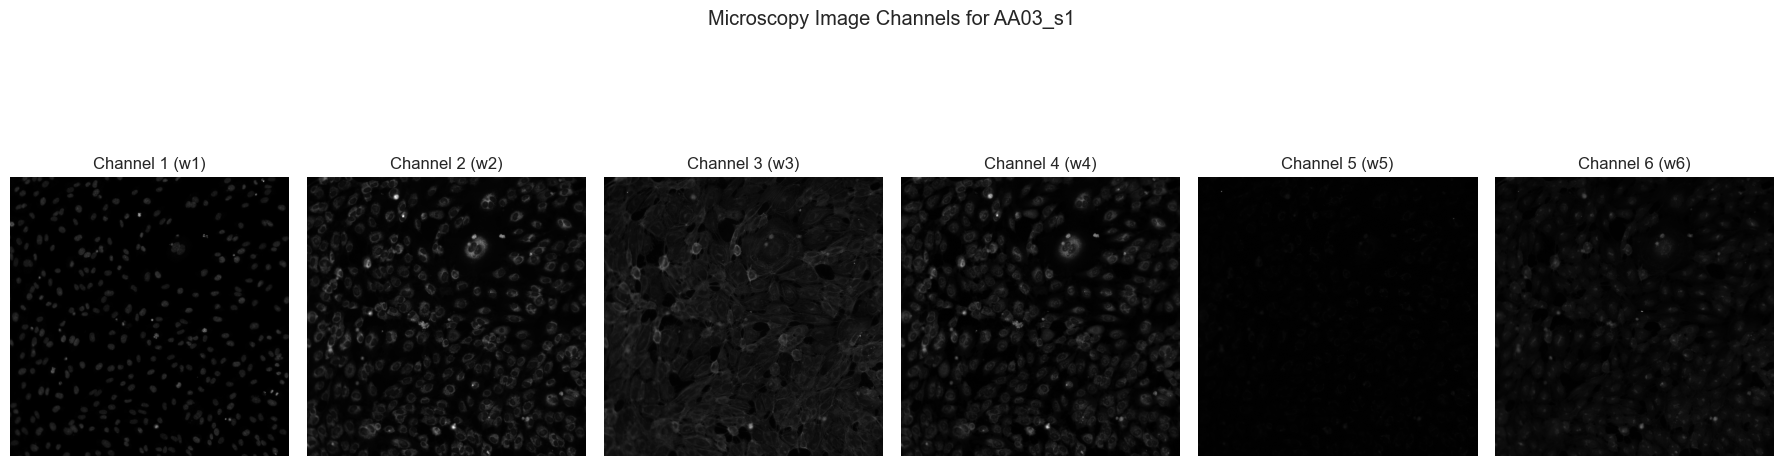

In [16]:

import glob
def visualize_well_channels(base_path, well, site, show_filenames=False):
    """
    Visualize all 6 channels for a specific well and site from an unsorted directory.
    
    Args:
        base_path (str): Path to the directory containing all image files
        well (str): Well code (e.g., 'AA03')
        site (str): Site identifier (e.g., 's1')
        show_filenames (bool): Whether to display filenames in the plot
    """
    pattern = f"{well}_{site}_w*.png"
    matching_files = sorted(glob.glob(os.path.join(base_path, pattern)))
    if not matching_files:
        print(f"No images found for well {well}, site {site} in {base_path}")
        return
    
    print(f"Found {len(matching_files)} channel images")
    images = [Image.open(img_path) for img_path in matching_files]
    # Create a figure with subplots for each channel
    fig, axes = plt.subplots(1, len(images), figsize=(18, 6))
    if len(images) == 1:
        axes = [axes]
    for i, (ax, img, img_path) in enumerate(zip(axes, images, matching_files)):
        ax.imshow(img, cmap="gray")
        # Extract channel number from filename
        filename = os.path.basename(img_path)
        channel = filename.split('_')[-1].split('.')[0]  # Get 'w1' from 'AA03_s1_w1.png'
        if show_filenames:
            ax.set_title(f"Channel {i+1} ({channel})\n{filename}")
        else:
            ax.set_title(f"Channel {i+1} ({channel})")
        ax.axis("off")
    plt.suptitle(f"Microscopy Image Channels for {well}_{site}")
    plt.tight_layout()
    plt.show()

# Example usage
base_path = "/Users/lucrieffel/Desktop/UC_Berkeley/MIDS_207_AppliedML/Final_Project/rxrx2/immune_images"
well = "AA03"
site = "s1"

visualize_well_channels(base_path, well, site)

In [17]:
balanced_subcats = []
min_samples = min(immune_df_v3['treatment_subcategory'].value_counts())

for subcat in immune_df_v3["treatment_subcategory"].unique():
    group = immune_df_v3[immune_df_v3["treatment_subcategory"] == subcat]
    group_downsampled = resample(group, replace=False, n_samples=min_samples, random_state=42)
    balanced_subcats.append(group_downsampled)

# Combine all downsampled groups
immune_df_v4 = pd.concat(balanced_subcats).reset_index(drop=True)

changing strategy to doing control versus 1 category

In [18]:
subcat = "Chemokines"

df_control = immune_df_v4[immune_df_v4["treatment_subcategory"] == "Control"]
df_subcat  = immune_df_v4[immune_df_v4["treatment_subcategory"] == subcat]

df_binary = pd.concat([df_control, df_subcat]).reset_index(drop=True)
df_binary["binary_label"] = df_binary["treatment_subcategory"].apply(lambda x: 0 if x == "Control" else 1)

channel_map = {
    "Hoechst": "w1",
    "Syto14": "w2",
    "ConA": "w3",
    "WGA": "w4",
    "MitoTracker": "w5",
    "Phalloidin": "w6"
}

for stain, w in channel_map.items():
    df_binary[stain] = df_binary.apply(
        lambda row: os.path.join(base_dir, f"{row['well']}_s{row['site']}_{w}.png"),
        axis=1
    )


The goal now is to read dataset - then only going to do 1 stain at a time the options for all 6 stain options

In [19]:
#cell 1
# Update ImmuneDataset class to handle missing files
class ImmuneDataset:
    def __init__(self, dataframe, label_col="treatment_subcategory", stain_cols=["Hoechst", "Syto14", "MitoTracker"]):
        self.df = dataframe.reset_index(drop=True)
        self.label_col = label_col
        self.stain_cols = stain_cols

        self.label2idx = {label: i for i, label in enumerate(sorted(self.df[label_col].unique()))}
        self.idx2label = {i: label for label, i in self.label2idx.items()}

    def generator(self):
        for _, row in self.df.iterrows():
            label = self.label2idx[row[self.label_col]]
            treatment_conc = row['treatment_conc'] if pd.notna(row['treatment_conc']) else 0.0

            # Load and stack selected stains
            images = []
            for stain in self.stain_cols:
                img = Image.open(row[stain]).resize((224, 224))
                img = np.array(img).astype(np.float32)
                mean = img.mean()
                std = img.std()
                if std > 0:
                    img = (img - mean) / std
                images.append(img)

            stacked = np.stack(images, axis=-1)  # Shape: (224, 224, C)
            yield [stacked, np.array([treatment_conc])], np.int32(label)

In [20]:
stain_cols = list(channel_map.keys())  # All 6 stains

dataset = ImmuneDataset(
    dataframe=df_binary,
    label_col="binary_label",
    stain_cols=stain_cols
)


In [21]:
dataset

In [22]:
#cell 2

# Create dataset
# immune_dataset = ImmuneDataset(immune_df_v4, label_col="treatment_subcategory", stain_cols=["Hoechst", "Syto14", "MitoTracker"])

#extract images and labels for generator
def extract_numpy_from_dataset(dataset_obj):
    """Extract images, treatment concentrations and labels from dataset with progress updates."""
    images = []
    treatment_concs = []
    labels = []
    
    # Get total number of rows for progress tracking
    total_rows = len(dataset_obj.df)
    print(f"Starting to process {total_rows} images...")
    
    # For tracking progress
    last_percent = 0
    processed = 0
    skipped = 0
    
    try:
        from tqdm import tqdm
        progress_iter = tqdm(enumerate(dataset_obj.df.iterrows()), total=total_rows)
    except ImportError:
        progress_iter = enumerate(dataset_obj.df.iterrows())
    
    for row_idx, (_, row) in progress_iter:
        try:
            label = dataset_obj.label2idx[row[dataset_obj.label_col]]
            treatment_conc = row['treatment_conc'] if pd.notna(row['treatment_conc']) else 0.0
            
            # Load and stack selected stains
            stain_images = []
            for stain_idx, stain in enumerate(dataset_obj.stain_cols):
                img_path = row[stain]
                
                # Check if file exists
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"Missing file: {img_path}")
                
                # Load and process image
                img = Image.open(img_path).resize((224, 224))
                img = np.array(img).astype(np.float32)
                mean = img.mean()
                std = img.std()
                if std > 0:
                    img = (img - mean) / std
                stain_images.append(img)
            
            # Stack all stains for this sample
            stacked = np.stack(stain_images, axis=-1)  # Shape: (224, 224, C)
            
            # Add to our collection
            images.append(stacked)
            treatment_concs.append(treatment_conc)
            labels.append(label)
            processed += 1
            
        except FileNotFoundError as e:
            skipped += 1
            if skipped <= 10:  # Only show first 10 errors to avoid flooding console
                if not 'tqdm' in sys.modules:  # Only print if not using tqdm
                    print(f"Skipping row {row_idx}: {str(e)}")
        
        # Print progress updates (if not using tqdm)
        if not 'tqdm' in sys.modules:
            current_percent = int(100 * (row_idx + 1) / total_rows)
            if current_percent > last_percent and current_percent % 5 == 0:
                print(f"Progress: {current_percent}% ({processed} processed, {skipped} skipped)")
                last_percent = current_percent
    
    print(f"\nProcessing complete!")
    print(f"Total rows processed: {processed}/{total_rows}")
    print(f"Rows skipped due to missing files: {skipped}")
    
    if not images:
        raise ValueError("No valid images found. Check file paths and directory structure.")
    
    # Convert to numpy arrays
    print("Converting to numpy arrays...")
    images_array = np.stack(images).astype(np.float32)
    treatment_concs_array = np.array(treatment_concs).astype(np.float32).reshape(-1, 1)
    labels_array = np.array(labels)
    
    print(f"Final array shapes: images {images_array.shape}, treatment_concs {treatment_concs_array.shape}, labels {labels_array.shape}")
    return [images_array, treatment_concs_array], labels_array

In [23]:
#extract images and labels
# images, labels = extract_numpy_from_dataset(dataset)
# print("Image shape:", images.shape)
# print("Label shape:", labels.shape)
# print("Class counts:", np.bincount(labels))

# Extract images and labels
X_train, y_train = extract_numpy_from_dataset(dataset)

# Now X_train is a list containing [images, treatment_concs]
print("Images shape:", X_train[0].shape)  # This will show (1726, 224, 224, 6)
print("Treatment concentrations shape:", X_train[1].shape)  # This will show (1726, 1)
print("Labels shape:", y_train.shape)  # This will show (1726,)
print("Class counts:", np.bincount(y_train))

Starting to process 1726 images...


100%|██████████| 1726/1726 [02:23<00:00, 12.07it/s]



Processing complete!
Total rows processed: 1726/1726
Rows skipped due to missing files: 0
Converting to numpy arrays...
Final array shapes: images (1726, 224, 224, 6), treatment_concs (1726, 1), labels (1726,)
Images shape: (1726, 224, 224, 6)
Treatment concentrations shape: (1726, 1)
Labels shape: (1726,)
Class counts: [863 863]


In [24]:
# Show label mapping
print(dataset.label2idx)

{0: 0, 1: 1}


In [25]:
def preprocess_data_part2(images, labels, split):
    """
    Preprocess data for model training.
    
    Args:
        images: List containing [image_data, treatment_concs]
        labels: Array of labels
        split: Tuple of (train_ratio, val_ratio, test_ratio)
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
    """
    # Unpack the images list
    image_data, treatment_concs = images
    
    # Set random seed for reproducibility
    np.random.seed(1234)
    
    # Create index to shuffle order
    index = np.arange(image_data.shape[0])
    # Shuffle order
    np.random.shuffle(index)
    
    # Shuffle data
    image_data = image_data[index]
    treatment_concs = treatment_concs[index]
    labels = labels[index]
    
    # Calculate split indices
    train_idx = int(split[0] * len(image_data))
    val_idx = train_idx + int(split[1] * len(image_data))
    
    # Split data
    X_train = [image_data[:train_idx], treatment_concs[:train_idx]]
    y_train = labels[:train_idx]
    
    X_val = [image_data[train_idx:val_idx], treatment_concs[train_idx:val_idx]]
    y_val = labels[train_idx:val_idx]
    
    X_test = [image_data[val_idx:], treatment_concs[val_idx:]]
    y_test = labels[val_idx:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [27]:
# define splits
split = (0.6, 0.2, 0.2)

# Unpack the images list
image_data, treatment_concs = X_train

# Set random seed for reproducibility
np.random.seed(1234)

# Create index to shuffle order
index = np.arange(image_data.shape[0])
# Shuffle order
np.random.shuffle(index)

# Shuffle data
image_data = image_data[index]
treatment_concs = treatment_concs[index]
labels = y_train[index]

# Calculate split indices
train_idx = int(split[0] * len(image_data))
val_idx = train_idx + int(split[1] * len(image_data))

# Split data
X_train = [image_data[:train_idx], treatment_concs[:train_idx]]
y_train = labels[:train_idx]

X_val = [image_data[train_idx:val_idx], treatment_concs[train_idx:val_idx]]
y_val = labels[train_idx:val_idx]

X_test = [image_data[val_idx:], treatment_concs[val_idx:]]
y_test = labels[val_idx:]

# Print shapes
print(f"X_train[0] shape (images): {X_train[0].shape}")
print(f"X_train[1] shape (treatment_concs): {X_train[1].shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val[0] shape (images): {X_val[0].shape}")
print(f"X_val[1] shape (treatment_concs): {X_val[1].shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test[0] shape (images): {X_test[0].shape}")
print(f"X_test[1] shape (treatment_concs): {X_test[1].shape}")
print(f"y_test shape: {y_test.shape}")

X_train[0] shape (images): (1035, 224, 224, 6)
X_train[1] shape (treatment_concs): (1035, 1)
y_train shape: (1035,)
X_val[0] shape (images): (345, 224, 224, 6)
X_val[1] shape (treatment_concs): (345, 1)
y_val shape: (345,)
X_test[0] shape (images): (346, 224, 224, 6)
X_test[1] shape (treatment_concs): (346, 1)
y_test shape: (346,)


In [28]:
def augment_images(X):
    X_aug = tf.image.flip_left_right(X)
    X_aug = tf.image.adjust_brightness(X_aug, delta=0.1)
    X_aug = tf.image.adjust_contrast(X_aug, contrast_factor=1.3)
    return X_aug

In [29]:

# X_train is now a list [images, treatment_concs]
X_train_images = X_train[0]  # Get the image data
X_train_concs = X_train[1]   # Get the treatment concentrations

# Augment only the images
X_train_augm = augment_images(X_train_images)

# Concatenate original and augmented images
X_train_images = tf.concat([X_train_images, X_train_augm], axis=0)

# Duplicate treatment concentrations to match augmented images
X_train_concs = tf.concat([X_train_concs, X_train_concs], axis=0)

# Recreate X_train as a list with both components
X_train = [X_train_images, X_train_concs]

# Duplicate labels to match augmented data
y_train = tf.concat([y_train, y_train], axis=0)  # same labels

In [30]:
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras import layers, models, Input

# Step 1: Input 6-channel image
input_layer = Input(shape=(224, 224, 6), name="6_channel_input")
treatment_conc_input = Input(shape=(1,), name="treatment_conc_input")

# Step 2: Learnable projection from 6 → 3
projected = layers.Conv2D(3, (1, 1), activation='linear', padding='same')(input_layer)

# Step 3: Create DenseNet using input_shape, not input_tensor
densenet_base = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Step 4: Apply base model to projected input
x = densenet_base(projected)

# Add Global Average Pooling to reduce spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

#Step 5: Process treatment concentration
conc_features = layers.Dense(32, activation='relu')(treatment_conc_input)
conc_features = layers.Dropout(0.2)(conc_features)

#combine layers
combined = layers.Concatenate()([x, conc_features])

# Step 6: Add classification head
x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)#sigmoid for binary classification

# Step 7: Build model
model = models.Model(inputs=[input_layer, treatment_conc_input], outputs=output)

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 455s 6s/step - accuracy: 0.4879 - loss: 0.7217 - val_accuracy: 0.4667 - val_loss: 0.7040
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 410s 6s/step - accuracy: 0.7916 - loss: 0.5163 - val_accuracy: 0.5014 - val_loss: 0.8419
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 400s 6s/step - accuracy: 0.9245 - loss: 0.2591 - val_accuracy: 0.5043 - val_loss: 1.4812
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - accuracy: 0.9381 - loss: 0.1598 - val_accuracy: 0.4812 - val_loss: 1.2590


In [32]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"Final training accuracy: {train_acc[-1]:.2%}")
print(f"Final validation accuracy: {val_acc[-1]:.2%}")


Final training accuracy: 93.19%
Final validation accuracy: 48.12%


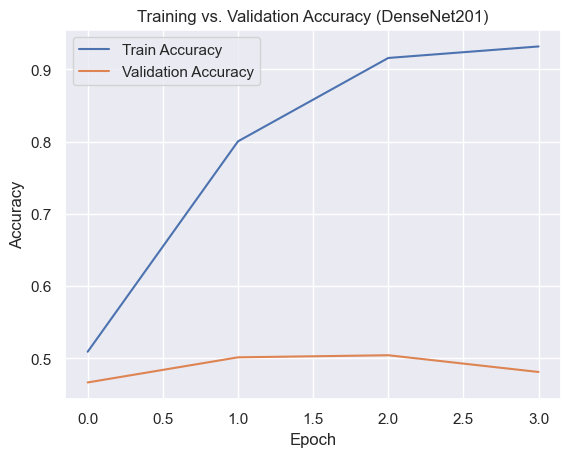

In [33]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy (DenseNet201)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy (Control vs Chemokines): {test_acc:.2%}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 837ms/step - accuracy: 0.5483 - loss: 0.6797
Test Accuracy (Control vs Chemokines): 55.49%


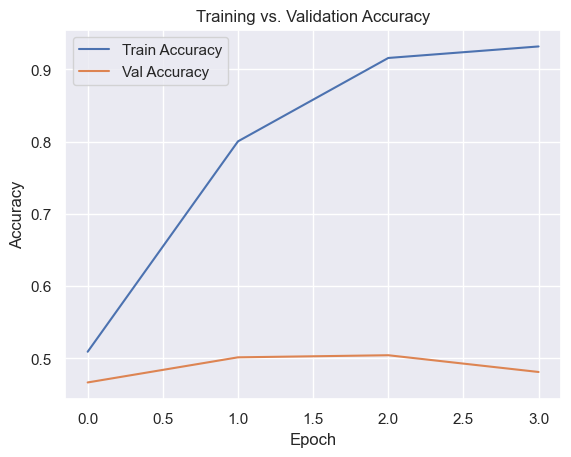

In [35]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
#classification report
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       171
           1       0.55      0.64      0.59       175

    accuracy                           0.55       346
   macro avg       0.56      0.55      0.55       346
weighted avg       0.56      0.55      0.55       346



In [37]:
#save model
model.save("model_treatment_conc_chemokines.h5")

In [38]:
model.save("model_treatment_conc_chemokines.keras")

# Model to focus only on Interferons: 

In [39]:
#had to convert them both to string
embedded_images["site_id"] = embedded_images["site_id"].astype(str)
metadata["site_id"] = metadata["site_id"].astype(str)

metadata.head()


,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,treatment_category,treatment_subcategory
0,HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,Sonic-Hedgehog,0.1,N/A,N/A
1,HUVEC-1_1_AA03_2,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,2,Sonic-Hedgehog,0.1,N/A,N/A
2,HUVEC-1_1_AA03_3,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,3,Sonic-Hedgehog,0.1,N/A,N/A
3,HUVEC-1_1_AA03_4,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,4,Sonic-Hedgehog,0.1,N/A,N/A
4,HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,GDF-1,0.1,N/A,N/A


In [42]:
immune_modulators = {
    "Interferons": [
        "IFN-alpha-A", "IFNB-1", "IFN-gamma", "IFN-omega"
    ]
}

# Create a lookup dictionary for fast mapping
immune_treatment_to_category = {}
for subcategory, treatments in immune_modulators.items():
    for treatment in treatments:
        immune_treatment_to_category[treatment] = ("Immune System Modulators", subcategory)

# Function to assign category and subcategory
def categorize_treatment(treatment):
    if treatment == "EMPTY":
        return "Control", "Control"  # Control case
    return immune_treatment_to_category.get(treatment, ("N/A", "N/A"))  # Assign category if found, else N/A

# Apply the categorization to the dataframe
metadata[["treatment_category", "treatment_subcategory"]] = metadata["treatment"].apply(lambda x: pd.Series(categorize_treatment(x)))

#remove the NA rows
immune_df = metadata[metadata["treatment_category"] != "N/A"]

In [43]:
#rename beta column 
immune_df["treatment"] = immune_df["treatment"].replace("IFNB-1", "IFN-beta")
immune_df['treatment'].value_counts()


treatment
EMPTY          7579
IFN-omega       288
IFN-alpha-A     288
IFN-gamma       287
IFNB-1          287
Name: count, dtype: int64

In [45]:
# Downsample so that control has same amount 
immune_df_v3 = immune_df.reset_index(drop=True)

immune_df_balanced = (
    immune_df_v3
    .groupby("treatment", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 287), random_state=42))
    .reset_index(drop=True)
)

immune_df_balanced['treatment'].value_counts()


/var/folders/d9/pw3fpxsn6z36z5c4m9bl4g140000gn/T/ipykernel_5303/3101398618.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 287), random_state=42))


treatment
EMPTY          287
IFN-alpha-A    287
IFN-gamma      287
IFN-omega      287
IFNB-1         287
Name: count, dtype: int64

In [ ]:
#cell 1
# Update ImmuneDataset class to handle missing files
class ImmuneDataset: #uses all 6 stain cols
    def __init__(self, dataframe, label_col="treatment_subcategory", stain_cols= ["Hoechst", "ConA", "Phalloidin", "Syto14", "MitoTracker", "WGA"]):
        self.df = dataframe.reset_index(drop=True)
        self.label_col = label_col
        self.stain_cols = stain_cols

        self.label2idx = {label: i for i, label in enumerate(sorted(self.df[label_col].unique()))}
        self.idx2label = {i: label for label, i in self.label2idx.items()}

    def generator(self):
        for _, row in self.df.iterrows():
            label = self.label2idx[row[self.label_col]]
            treatment_conc = row['treatment_conc'] if pd.notna(row['treatment_conc']) else 0.0

            # Load and stack selected stains
            images = []
            for stain in self.stain_cols:
                img = Image.open(row[stain]).resize((224, 224))
                img = np.array(img).astype(np.float32)
                mean = img.mean()
                std = img.std()
                if std > 0:
                    img = (img - mean) / std
                images.append(img)

            stacked = np.stack(images, axis=-1)  # Shape: (224, 224, C)
            yield [stacked, np.array([treatment_conc])], np.int32(label)

In [49]:
stain_cols = list(channel_map.keys())  # All 6 stains

dataset = ImmuneDataset(
    dataframe=df_binary,
    label_col="binary_label",
    stain_cols=stain_cols
)


In [50]:
dataset

In [53]:

#extract images and labels for generator
def extract_numpy_from_dataset(dataset_obj):
    """Extract images, treatment concentrations and labels from dataset with progress updates."""
    images = []
    treatment_concs = []
    labels = []
    
    # Get total number of rows for progress tracking
    total_rows = len(dataset_obj.df)
    print(f"Starting to process {total_rows} images...")
    
    # For tracking progress
    last_percent = 0
    processed = 0
    skipped = 0
    
    try:
        from tqdm import tqdm
        progress_iter = tqdm(enumerate(dataset_obj.df.iterrows()), total=total_rows)
    except ImportError:
        progress_iter = enumerate(dataset_obj.df.iterrows())
    
    for row_idx, (_, row) in progress_iter:
        try:
            label = dataset_obj.label2idx[row[dataset_obj.label_col]]
            treatment_conc = row['treatment_conc'] if pd.notna(row['treatment_conc']) else 0.0
            
            # Load and stack selected stains
            stain_images = []
            for stain_idx, stain in enumerate(dataset_obj.stain_cols):
                img_path = row[stain]
                
                # Check if file exists
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"Missing file: {img_path}")
                
                # Load and process image
                img = Image.open(img_path).resize((224, 224))
                img = np.array(img).astype(np.float32)
                mean = img.mean()
                std = img.std()
                if std > 0:
                    img = (img - mean) / std
                stain_images.append(img)
            
            # Stack all stains for this sample
            stacked = np.stack(stain_images, axis=-1)  # Shape: (224, 224, C)
            
            # Add to our collection
            images.append(stacked)
            treatment_concs.append(treatment_conc)
            labels.append(label)
            processed += 1
            
        except FileNotFoundError as e:
            skipped += 1
            if skipped <= 10:  # Only show first 10 errors to avoid flooding console
                if not 'tqdm' in sys.modules:  # Only print if not using tqdm
                    print(f"Skipping row {row_idx}: {str(e)}")
        
        # Print progress updates (if not using tqdm)
        if not 'tqdm' in sys.modules:
            current_percent = int(100 * (row_idx + 1) / total_rows)
            if current_percent > last_percent and current_percent % 5 == 0:
                print(f"Progress: {current_percent}% ({processed} processed, {skipped} skipped)")
                last_percent = current_percent
    
    print(f"\nProcessing complete!")
    print(f"Total rows processed: {processed}/{total_rows}")
    print(f"Rows skipped due to missing files: {skipped}")
    
    if not images:
        raise ValueError("No valid images found. Check file paths and directory structure.")
    
    # Convert to numpy arrays
    print("Converting to numpy arrays...")
    images_array = np.stack(images).astype(np.float32)
    treatment_concs_array = np.array(treatment_concs).astype(np.float32).reshape(-1, 1)
    labels_array = np.array(labels)
    
    print(f"Final array shapes: images {images_array.shape}, treatment_concs {treatment_concs_array.shape}, labels {labels_array.shape}")
    return [images_array, treatment_concs_array], labels_array

In [54]:
# Extract images and labels
X_train, y_train = extract_numpy_from_dataset(dataset)

# Now X_train is a list containing [images, treatment_concs]
print("Images shape:", X_train[0].shape)  # This will show (1726, 224, 224, 6)
print("Treatment concentrations shape:", X_train[1].shape)  # This will show (1726, 1)
print("Labels shape:", y_train.shape)  # This will show (1726,)
print("Class counts:", np.bincount(y_train))

Starting to process 1726 images...


100%|██████████| 1726/1726 [02:27<00:00, 11.69it/s]



Processing complete!
Total rows processed: 1726/1726
Rows skipped due to missing files: 0
Converting to numpy arrays...
Final array shapes: images (1726, 224, 224, 6), treatment_concs (1726, 1), labels (1726,)
Images shape: (1726, 224, 224, 6)
Treatment concentrations shape: (1726, 1)
Labels shape: (1726,)
Class counts: [863 863]


In [55]:
# Show label mapping
print(dataset.label2idx)

{0: 0, 1: 1}


In [56]:
def preprocess_data_part2(images, labels, split):
    """
    Preprocess data for model training.
    
    Args:
        images: List containing [image_data, treatment_concs]
        labels: Array of labels
        split: Tuple of (train_ratio, val_ratio, test_ratio)
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
    """
    # Unpack the images list
    image_data, treatment_concs = images
    
    # Set random seed for reproducibility
    np.random.seed(1234)
    
    # Create index to shuffle order
    index = np.arange(image_data.shape[0])
    # Shuffle order
    np.random.shuffle(index)
    
    # Shuffle data
    image_data = image_data[index]
    treatment_concs = treatment_concs[index]
    labels = labels[index]
    
    # Calculate split indices
    train_idx = int(split[0] * len(image_data))
    val_idx = train_idx + int(split[1] * len(image_data))
    
    # Split data
    X_train = [image_data[:train_idx], treatment_concs[:train_idx]]
    y_train = labels[:train_idx]
    
    X_val = [image_data[train_idx:val_idx], treatment_concs[train_idx:val_idx]]
    y_val = labels[train_idx:val_idx]
    
    X_test = [image_data[val_idx:], treatment_concs[val_idx:]]
    y_test = labels[val_idx:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [57]:
# define splits
split = (0.6, 0.2, 0.2)

# Unpack the images list
image_data, treatment_concs = X_train

# Set random seed for reproducibility
np.random.seed(1234)

# Create index to shuffle order
index = np.arange(image_data.shape[0])
# Shuffle order
np.random.shuffle(index)

# Shuffle data
image_data = image_data[index]
treatment_concs = treatment_concs[index]
labels = y_train[index]

# Calculate split indices
train_idx = int(split[0] * len(image_data))
val_idx = train_idx + int(split[1] * len(image_data))

# Split data
X_train = [image_data[:train_idx], treatment_concs[:train_idx]]
y_train = labels[:train_idx]

X_val = [image_data[train_idx:val_idx], treatment_concs[train_idx:val_idx]]
y_val = labels[train_idx:val_idx]

X_test = [image_data[val_idx:], treatment_concs[val_idx:]]
y_test = labels[val_idx:]

# Print shapes
print(f"X_train[0] shape (images): {X_train[0].shape}")
print(f"X_train[1] shape (treatment_concs): {X_train[1].shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val[0] shape (images): {X_val[0].shape}")
print(f"X_val[1] shape (treatment_concs): {X_val[1].shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test[0] shape (images): {X_test[0].shape}")
print(f"X_test[1] shape (treatment_concs): {X_test[1].shape}")
print(f"y_test shape: {y_test.shape}")

X_train[0] shape (images): (1035, 224, 224, 6)
X_train[1] shape (treatment_concs): (1035, 1)
y_train shape: (1035,)
X_val[0] shape (images): (345, 224, 224, 6)
X_val[1] shape (treatment_concs): (345, 1)
y_val shape: (345,)
X_test[0] shape (images): (346, 224, 224, 6)
X_test[1] shape (treatment_concs): (346, 1)
y_test shape: (346,)


In [58]:
def augment_images(X):
    X_aug = tf.image.flip_left_right(X)
    X_aug = tf.image.adjust_brightness(X_aug, delta=0.1)
    X_aug = tf.image.adjust_contrast(X_aug, contrast_factor=1.3)
    return X_aug

In [59]:

# X_train is now a list [images, treatment_concs]
X_train_images = X_train[0]  # Get the image data
X_train_concs = X_train[1]   # Get the treatment concentrations

# Augment only the images
X_train_augm = augment_images(X_train_images)

# Concatenate original and augmented images
X_train_images = tf.concat([X_train_images, X_train_augm], axis=0)

# Duplicate treatment concentrations to match augmented images
X_train_concs = tf.concat([X_train_concs, X_train_concs], axis=0)

# Recreate X_train as a list with both components
X_train = [X_train_images, X_train_concs]

# Duplicate labels to match augmented data
y_train = tf.concat([y_train, y_train], axis=0)  # same labels

In [60]:
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras import layers, models, Input

# Step 1: Input 6-channel image
input_layer = Input(shape=(224, 224, 6), name="6_channel_input")
treatment_conc_input = Input(shape=(1,), name="treatment_conc_input")

# Step 2: Learnable projection from 6 → 3
projected = layers.Conv2D(3, (1, 1), activation='linear', padding='same')(input_layer)

# Step 3: Create DenseNet using input_shape, not input_tensor
densenet_base = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Step 4: Apply base model to projected input
x = densenet_base(projected)

# Add Global Average Pooling to reduce spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

#Step 5: Process treatment concentration
conc_features = layers.Dense(32, activation='relu')(treatment_conc_input)
conc_features = layers.Dropout(0.2)(conc_features)

#combine layers
combined = layers.Concatenate()([x, conc_features])

# Step 6: Add classification head
x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)#sigmoid for binary classification

# Step 7: Build model
model = models.Model(inputs=[input_layer, treatment_conc_input], outputs=output)

In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 475s 7s/step - accuracy: 0.5063 - loss: 0.7293 - val_accuracy: 0.5130 - val_loss: 0.7016
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 431s 7s/step - accuracy: 0.8145 - loss: 0.5047 - val_accuracy: 0.4783 - val_loss: 0.8210
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 449s 7s/step - accuracy: 0.9323 - loss: 0.2324 - val_accuracy: 0.4783 - val_loss: 1.2246
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 442s 7s/step - accuracy: 0.9563 - loss: 0.1278 - val_accuracy: 0.4464 - val_loss: 1.8780


In [62]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"Final training accuracy: {train_acc[-1]:.2%}")
print(f"Final validation accuracy: {val_acc[-1]:.2%}")


Final training accuracy: 95.02%
Final validation accuracy: 44.64%


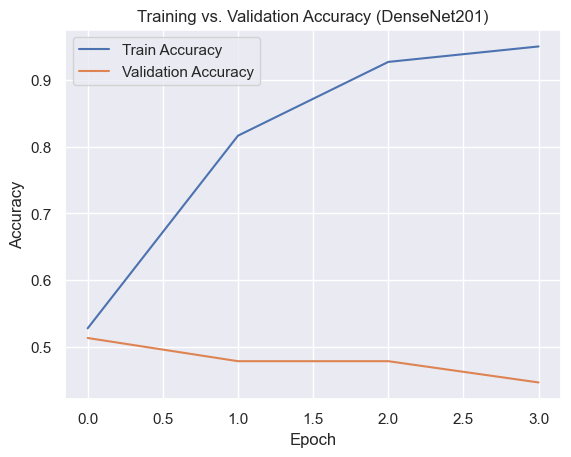

In [63]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy (DenseNet201)')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy (Control vs Interferons): {test_acc:.2%}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 832ms/step - accuracy: 0.5688 - loss: 0.6847
Test Accuracy (Control vs Interferons): 53.18%


In [65]:
#classification report
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
              precision    recall  f1-score   support

           0       0.62      0.14      0.23       171
           1       0.52      0.91      0.66       175

    accuracy                           0.53       346
   macro avg       0.57      0.53      0.45       346
weighted avg       0.57      0.53      0.45       346



In [66]:
model.save("model_treatment_conc_interferons.h5")
model.save("model_treatment_conc_interferons.keras")
